# <center>Projet Gestion des Risques EDP</center>
### <center>SEHRINE Liza</center>



# Introduction au Projet EDP en Finance

Ce projet s'inscrit dans le domaine fascinant qui croise les équations aux dérivées partielles (EDP) et le secteur complexe de la finance. Plus précisément, notre objectif est la résolution d'équation fondamentale qui régit l'évolution d'une variable financière essentielle dans les dimensions temporelles et spatiales.

L'équation que nous explorons est formulée comme suit :
$$
\frac{\partial u(t, x)}{\partial t} + c(t, x) \cdot u(t, x) = A_tu(t, x) + d(t, x)
$$

où la partie la plus cruciale, $A_tu(t, x)$, est définie comme une combinaison complexe de dérivées secondaires et premières par rapport à la variable spatiale $x$. Plus précisément, $A_tu(t, x)$ se compose de $a(t, x)$ multiplié par la seconde dérivée $ \frac{\partial^2 u(t, x)}{\partial x^2} $ et $b(t, x)$ multiplié par la première dérivée $ \frac{\partial u(t, x)}{\partial x} $. Cette formulation mathématique sophistiquée capture les nuances inhérentes aux processus financiers.

Dans le contexte financier, $u(t, x)$ représente une quantité clé, telle qu'un prix d'actif, et les coefficients $c(t, x)$, $a(t, x)$, et $b(t, x)$ décrivent les caractéristiques du marché et des actifs financiers. Le terme $d(t, x)$ peut quantifier des influences externes ou des irrégularités dans le système.

Notre objectif est de résoudre cette équation pour   $t \in [t^-, t^+]$ et $x \in [x^-, x^+]$. Pour atteindre cet objectif, nous optons pour la méthode des différences finies. Cette approche se révèle particulièrement adaptée pour résoudre les problèmes d'équations aux dérivées partielles (EDP) paraboliques d'ordre 2 en $x$.

In [14]:
#importation des Bibliothèques
import math
import numpy as np
import matplotlib as plt
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
import multiprocessing

# <center>Modèle de Black & Scholes</center>

### Le modèle de valorisation des options de Black et Scholes (1973) satisfait, pour une option européenne d'achat $ C(\tau, S)$, l'équation aux dérivées partielles suivante :

$$
\begin{cases}
C(0, S) = \max(S - K, 0) \\
\frac{1}{2}\sigma^2(t,x)S^2\frac{\partial^2C}{\partial S^2} + bS\frac{\partial C}{\partial S} = \frac{\partial C}{\partial \tau} + rC
\end{cases}
$$

où $b$ représente le paramètre de coût de portage (cost-of-carry).

Dans cette équation, $C(0, S)$ est la valeur de l'option au moment initial, définie comme le maximum entre la différence entre le prix de l'actif sous-jacent $S$ et le prix d'exercice $K$, et zéro $( \max(S - K, 0) $.

La deuxième équation exprime l'évolution de la valeur de l'option par rapport au temps $\tau $ et au prix de l'actif sous-jacent $S $. Les termes $\sigma^2(t,x)$, $ b $, $ r$ sont des paramètres du modèle, représentant respectivement la volatilité, le coût de portage et le taux d'intérêt sans risque.

In [15]:
#Paramètres 
teta= 0.5
K=100
sigma = 0.20
tau = 0.25
r=0.08
b=-0.04

xmin = 50
xmax = 150
Nx = 201
tmin = 0
tmax = tau
Nt = 1000
k = (tmax-tmin)/(Nt-1)
h = (xmax - xmin)/(Nx-1)

### Paramètre du modèle

#### <center>Modèle de Black Scholes</center>

$$
\begin{cases}
C(0, S) = \max(S - K, 0) \\
\frac{1}{2}\sigma^2(t,x)S^2\frac{\partial^2C}{\partial S^2} + bS\frac{\partial C}{\partial S} = \frac{\partial C}{\partial \tau} + rC
\end{cases}
$$

avec :

1. $ a(t, x) = \frac{1}{2} \cdot (\sigma^2) \cdot x^2 $

2. $ b(t, x) = 0.04 \cdot x$

3. $ c(t, x) = r$

4. $ d(t, x) = 0$

5. $ tmin(t, x) = \max(x - K, 0)$

6. $xmax(t, x) = \max(x - K, 0)$

7. $ Dxmax(t, x) = 1 $

8. $ xmin(t, x) = 0 $

In [16]:
def a(t,x):
    return(0.5*(sigma**2)*x**2)

def b(t,x):
    return(0.04*x)

def c(t,x):
    return(r)

def d(t,x):
    return(0)

def tminBound(t,x):
    return(max(x - K,0))

def xmaxBound(t,x):
    return(max(x - K,0))

def DxmaxBound(t,x):
    return(1)

def xminBound(t,x):
    return(0)

### Condition aux bornes

Pour résoudre ce problème numérique, nous devons ajouter deux conditions aux bornes pour les valeurs extrêmes $S^-$ et $S^+$ prises par la variable $S$.

Pour $S^-$, nous choisissons la condition suivante :
$ u(t, S^-) = 0$

car le prix de l’option d’achat tend vers zéro lorsque le prix du sous-jacent décroît.

Pour S+, nous avons trois possibilités :

1. Nous pouvons imposer la condition de Dirichlet $u(t,S^+) = S^+ - K $ en raison des propriétés des options dans la monnaie (lorsque le prix du sous-jacent augmente, la valeur temps diminue et tend vers zéro).
2. Nous pouvons choisir la condition classique de Neumann $ u_S(t,S^+) = 0 $.
3. Nous pouvons aussi considérer la condition aux bornes suivante $ u_S(t,S^+) = 1$. La justification est la même que pour la première possibilité.

In [17]:
# Initialisation d'un tableau 'u_xmin' pour représenter les conditions aux bords associées à la borne minimale (xmin) du domaine spatial.
u_xmin = np.ones(Nt)

# Initialisation d'un tableau 'u_Nx_moins_un' pour représenter les conditions aux bords associées à la borne correspondant à (Nx - 1), où Nx est potentiellement le nombre total de points dans l'espace.
u_Nx_moins_un = np.ones(Nt)

In [18]:
# Liste des valeurs de t.
# Le résultat final est une liste de nombres allant de tmin à tmax avec un pas de h = (tmax - tmin)/(Nt-1)
def grid_t():
    # Calcul du pas entre les valeurs de t
    k = (tmax - tmin) / (Nt - 1)
    # On génère la matrice de dimension Nt x 1 qui stockera les valeurs de t
    Grid_t = np.zeros(Nt)
    # Boucle pour remplir les valeurs de t dans la matrice
    for m in range(Nt):
        Grid_t[m] = tmin + k * m
    return Grid_t

In [19]:
# Liste des valeurs de x.
# Le résultat final est une liste de nombres allant de xmin à xmax avec un pas de h = (xmax - xmin)/(Nx-1)
def grid_x():
    # Calcul du pas entre les valeurs de x
    h = (xmax - xmin) / (Nx - 1)
    # On génère la matrice de dimension Nx x 1 qui stockera les valeurs de x
    Grid_x = np.zeros(Nx)
    # Boucle pour remplir les valeurs de x dans la matrice
    for i in range(Nx):
        Grid_x[i] = xmin + h * i
    return Grid_x

En utilisant la méthode des différences centrales pour l’approximation d’une dérivée, nous obtenons les discrétisations dans l’espace:

$$
\frac{\partial u(t, x)}{\partial x} \approx \frac{u_{i+1} - u_{i-1}}{2h}
$$

$$
\frac{\partial^2 u(t, x)}{\partial x^2} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}
$$

Notre de départ s'écrit alors :
$$\frac{\partial u(t,x)}{\partial t} = B_{i}^m$$

avec :

$$B_{i}^m = A_{i}^m + d_{im} - c_{im} \cdot{u_i^m} + u_{i+1}^m $$

$$A_{i}^m  = a_{i}^m \cdot \frac{u_{i+1}^m - 2u_i^m + u_{i-1}^m}{h^2} + b_{i}^m \cdot \frac{u_{i+1}^m - u_{i-1}^m}{2h}$$

Pour se placer dans le cadre du schéma de Crank-Nicholson, il suffit de condiderer $θ = \frac{1}{2}$ .

Dans le cadre général, considérons les notations : 
$$\alpha_{i}^m = a_{i}^m  \cdot \frac{k}{h^2}- b_{i}^m \cdot \frac{ k}{2h}$$

$$\beta_{im} = 1 - 2a_{i}^m \cdot\frac{k}{h^2}  - c_{i}^m \cdot k $$

$$\gamma_{i}^m = a_{i}^m \cdot \frac{k}{h^2} + b_{i}^m \cdot \frac{k}{2h}$$

In [20]:
def alpha_(a,b,t,x):
    Alpha = a(t,x)*(k/h**2) - b(t,x)*k/(2*h)
    return(Alpha)
def beta_(a,c,t,x):
    Beta=1-2*a(t,x)*k/(h**2)-c(t,x)*k
    return(Beta)
def gamma_(a,b,t,x):
    Gamma=a(t,x)*k/(h**2)+b(t,x)*k/(2*h)
    return(Gamma)

$$
\begin{align*}
\chi_{i}^m &= (1-\theta) \cdot \alpha_{i}^m \\
\tau_{i}^m &= 1 + (1-\theta) \cdot (\beta_{i}^m - 1) \\
\upsilon_{i}^m &= (1-\theta) \cdot \gamma_{i}^m \\
\phi_{i}^m &= \theta \cdot \alpha_{i}^m \\
\Phi_{i}^m &= -1 + \theta \cdot (\beta_{i}^m - 1) \\
\chi_{i}^m &= \theta \cdot \gamma_{i}^m \\
\psi_{i}^m &= (1-\theta) \cdot d_{i}^{m-1} \cdot k + \theta \cdot d_{i}^m \cdot k \quad 
\end{align*}
$$


In [21]:
def ς_(a,b,c,d,teta,t,x,tprev):
    k = (tmax-tmin)/(Nt-1)
    Alpha =alpha_(a,b,t,x)
    Beta = beta_(a,c,t,x)
    Gamma = gamma_(a,b,t,x)
    ς = (1-teta)*Alpha
    return(ς)

def τ_(a,b,c,d,teta,t,x,tprev):
    k = (tmax-tmin)/(Nt-1)
    Alpha =alpha_(a,b,t,x)
    Beta = beta_(a,c,t,x)
    Gamma = gamma_(a,b,t,x)
    τ = 1 +(1-teta)*(Beta-1)
    return(τ)

def υ_(a, b, c, d, teta, t, x, tprev):
    k = (tmax - tmin) / (Nt - 1)
    Alpha = alpha_(a, b, t, x)
    Beta = beta_(a, c, t, x)
    Gamma = gamma_(a, b, t, x)
    υ = (1 - teta) * Gamma
    return υ

def φ_(a, b, c, d, teta, t, x, tprev):
    k = (tmax - tmin) / (Nt - 1)
    Alpha = alpha_(a, b, t, x)
    Beta = beta_(a, c, t, x)
    Gamma = gamma_(a, b, t, x)
    φ = teta * Alpha
    return φ

def ϕ_(a, b, c, d, teta, t, x, tprev):
    k = (tmax - tmin) / (Nt - 1)
    Alpha = alpha_(a, b, t, x)
    Beta = beta_(a, c, t, x)
    Gamma = gamma_(a, b, t, x)
    ϕ = -1 + teta * (Beta - 1)
    return ϕ

def χ_(a, b, c, d, teta, t, x, tprev):
    k = (tmax - tmin) / (Nt - 1)
    Alpha = alpha_(a, b, t, x)
    Beta = beta_(a, c, t, x)
    Gamma = gamma_(a, b, t, x)
    χ = teta * Gamma
    return χ

def ψ_(a, b, c, d, teta, t, x, tprev):
    k = (tmax - tmin) / (Nt - 1)
    Alpha = alpha_(a, b, t, x)
    Beta = beta_(a, c, t, x)
    Gamma = gamma_(a, b, t, x)
    if t != 0:
        ψ = (1 - teta) * d(tprev, x) * k + teta * d(t, x) * k
    else:
        ψ = teta * d(t, x) * k
    return ψ


In [22]:
def vect_ς(a, b, c, d, teta, t, tprev):
    ς = []
    for x in grid_x():
        ς.append(ς_(a, b, c, d, teta, t, x, tprev))
    return ς

def vect_τ(a, b, c, d, teta, t, tprev):
    τ = []
    for x in grid_x():
        τ.append(τ_(a, b, c, d, teta, t, x, tprev))
    return τ

def vect_υ(a, b, c, d, teta, t, tprev):
    υ = []
    for x in grid_x():
        υ.append(υ_(a, b, c, d, teta, t, x, tprev))
    return υ

def vect_φ(a, b, c, d, teta, t, tprev):
    φ = []
    for x in grid_x():
        φ.append(φ_(a, b, c, d, teta, t, x, tprev))
    return φ

def vect_ϕ(a, b, c, d, teta, t, tprev):
    ϕ = []
    for x in grid_x():
        ϕ.append(ϕ_(a, b, c, d, teta, t, x, tprev))
    return ϕ

def vect_χ(a, b, c, d, teta, t, tprev):
    χ = []
    for x in grid_x():
        χ.append(χ_(a, b, c, d, teta, t, x, tprev))
    return χ

def vect_ψ(a, b, c, d, teta, t, tprev):
    ψ = []
    for x in grid_x():
        ψ.append(ψ_(a, b, c, d, teta, t, x, tprev))
    return ψ




La solution numérique est obetnue en résolvant le système suivant :
$$
\phi_{mi} \cdot u_{i-1}^{m} + \phi_{i}^m \cdot u_{i}^{m} + \chi_{i}^m \cdot u_{i+1}^{m} = - [ \varsigma_{i}^{m-1} \cdot u_{i-1}^{m-1} + \tau_{i}{m-1} \cdot u_{i}{m-1} + \upsilon_{i}{m-1} \cdot u_{i+1}{m-1} + \psi_{i}{m}]
$$

L'écriture matricielle correspondante est 
$$
\Lambda_m \cdot \mathbf{u}_m = -[\mathbf{\Xi}_{m-1} \cdot \mathbf{u}_{m-1} + \mathbf{\Psi}_m] + \mathbf{\varepsilon}_m
$$

$$
\mathbf{u}^m = \begin{bmatrix} u_{1}^{m} \\ u_{2}^{m} \\ \vdots \\ u_{i}^{m} \\ \vdots \\ u_{Nx-2}^{m} \end{bmatrix}
$$


Les matrices $\Lambda_m$ et $\Xi_m$ correspondent à

$$
\Lambda_m = \begin{bmatrix}
\Phi_{1}^m & \chi_{1}^m & 0 & \dots & 0 \\
\phi_{2}^m & \Phi_{2}^m & \chi_{2}^m & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & \Phi_{(Nx-2)}^m
\end{bmatrix}
$$

et

$$
\Xi_m = \begin{bmatrix}
\tau_{1}^m & \upsilon_{1}^m & 0 & \dots & 0 \\
\upsilon_{2}^m & \tau_{2}^m & \upsilon_{2}^m & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 \vdots & &\upsilon_{(Nx-2)}^m & \tau_{(Nx-2)}^m
\end{bmatrix}
$$

In [23]:
def matrices_Λm(a, b, c, d, teta, m):
    diag_sup_Λm = []
    diag_Λm = []
    diag_inf_Λm = []
    diag_Λm.append(ϕ_(a, b, c, d, teta, grid_t()[m], grid_x()[0], grid_t()[m-1]))  # On ajoute ϕ(m,0) à la liste diag_Λm
    for i in range(1, Nx-1, 1):
        diag_Λm.append(ϕ_(a, b, c, d, teta, grid_t()[m], grid_x()[i], grid_t()[m-1]))  # On ajoute ϕ(m,i) à la liste diag_Λm
        diag_sup_Λm.append(χ_(a, b, c, d, teta, grid_t()[m], grid_x()[i-1], grid_t()[m-1]))  # On ajoute χ(m,i)
        diag_inf_Λm.append(φ_(a, b, c, d, teta, grid_t()[m], grid_x()[i+1], grid_t()[m-1]))  # On ajoute φ(m,i)
    Λm = (diag_sup_Λm, diag_Λm, diag_inf_Λm)
    return Λm

def matrices_Ξm(a, b, c, d, teta, m):
    diag_sup_Ξm = []
    diag_Ξm = []
    diag_inf_Ξm = []
    diag_Ξm.append(τ_(a, b, c, d, teta, grid_t()[m], grid_x()[0], grid_t()[m-1]))  # On ajoute τ(m,0) à la liste diag_Ξm
    for i in range(1, Nx-1, 1):
        diag_Ξm.append(τ_(a, b, c, d, teta, grid_t()[m], grid_x()[i], grid_t()[m-1]))  # On ajoute τ(m,i) à la liste diag_Ξm
        diag_sup_Ξm.append(υ_(a, b, c, d, teta, grid_t()[m], grid_x()[i-1], grid_t()[m-1]))  # On ajoute υ(m,i)
        diag_inf_Ξm.append(ς_(a, b, c, d, teta, grid_t()[m], grid_x()[i+1], grid_t()[m-1]))  # On ajoute ς(m,i)
    Ξm = (diag_sup_Ξm, diag_Ξm, diag_inf_Ξm)
    return Ξm

Le vecteur $\varepsilon_m$ est une fonction d'absorption résiduelle

$$
\mathbf{\varepsilon}_m = \begin{bmatrix}
-(\phi_{1}^m \cdot u_{0}^m + \varsigma_{1}^{m-1} \cdot u_0^{m-1}) \\
0 \\
\vdots \\
0 \\
-(\chi_{Nx-2}^{m} \cdot u_{Nx-1}^m + \upsilon_{Nx-2}^{m-1} \cdot u_{Nx-1}^{m-1})
\end{bmatrix}
$$

In [24]:
# Cette fonction calcule le vecteur εm qui est une fonction d'absorption résiduelle 
def εm(u_xmin, u_Nx_moins_un, m):
    εm = np.zeros(Nx)
    φ = φ_(a, b, c, d, teta, grid_t()[m], grid_x()[1], grid_t()[m-1])  # φ(m,1) 
    ς = ς_(a, b, c, d, teta, grid_t()[m-1], grid_x()[1], grid_t()[m-2])  # ς(m-1,1)
    χ = χ_(a, b, c, d, teta, grid_t()[m], grid_x()[Nx-2], grid_t()[m-1])  # χ(m,Nx-2)
    υ = υ_(a, b, c, d, teta, grid_t()[m-1], grid_x()[Nx-2], grid_t()[m-2])  # υ(m-1,Nx-2)
    εm[0] = -(φ * u_xmin[m] + ς * u_xmin[m-1])
    εm[-1] = -(χ * u_Nx_moins_un[m] + υ * u_Nx_moins_un[m-1])
    return εm

In [25]:
ε1=εm(u_xmin,u_Nx_moins_un,0)

In [26]:
def calcul_vm_plus_εm(uprev, ε, m):
    υ = vect_υ(a, b, c, d, teta, grid_t()[m], grid_t()[m-1])  # υ(m-1)
    ς = vect_ς(a, b, c, d, teta, grid_t()[m], grid_t()[m-1])  # ς(m-1)
    τ = vect_τ(a, b, c, d, teta, grid_t()[m], grid_t()[m-1])
    Ψ = vect_ψ(a, b, c, d, teta, grid_t()[m], grid_t()[m-1])
    res = np.zeros(Nx)
    res[0] = -ς[1] * uprev[0] + ε[0]
    res[-1] = -υ[Nx-2] * uprev[Nx-1] + ε[-1]
    for i in range(1, Nx-1, 1):
        res[i] = uprev[i-1] * ς[i] + uprev[i] * τ[i] + υ[i] * uprev[i+1] + Ψ[i]
    return res

In [27]:
v1_plus_ε_1 = calcul_vm_plus_εm(u_xmin,ε1,1)

Une nouvelle écriture du système est alors : 
$$ Λ_m · u_m = v_m + ε_m $$
avec $$v_m = − [Ξ_{m−1} · u_{m−1} + Ψ_m]$$

In [28]:
#Algorithme permettant de résoudre un système d'equations tridiagonale 
#Cet algorithme sera utilisé pour résoudre l'équation suivante:  Λm⋅um = vm+εm avec Λm la matrice tridiagonale
#a = Diagonale inférieur , b = Diagonale principale, c = Diagonale supérieur , d = vecteur solution 
def TDMASolve(a, b, c, d):
    n = len(a)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    xc = []
    for j in range(1, n):
        if(bc[j - 1] == 0):
            ier = 1
            return
        ac[j] = ac[j]/bc[j-1]
        bc[j] = bc[j] - ac[j]*cc[j-1]
    if(b[n-1] == 0):
        ier = 1
        return
    for j in range(1, n):
        dc[j] = dc[j] - ac[j]*dc[j-1]
    dc[n-1] = dc[n-1]/bc[n-1]
    for j in range(n-2, -1, -1):
        dc[j] = (dc[j] - cc[j]*dc[j+1])/bc[j]
    return dc

In [29]:
Λ = matrices_Λm(a,b,c,d,teta,0)
U_X1 = TDMASolve(Λ[2],Λ[1],Λ[0],v1_plus_ε_1)

In [30]:
Solution = [u_xmin]
uprev = u_xmin
ε = ε1

for t in range(len(grid_t())):
    v_plus_ε = calcul_vm_plus_εm(uprev, ε, t)
    Solution.append(TDMASolve(Λ[2], Λ[1], Λ[0], v_plus_ε))
    uprev = Solution[-1]
    ε = εm(u_xmin, u_Nx_moins_un, t)
    Λ = matrices_Λm(a, b, c, d, teta, t)

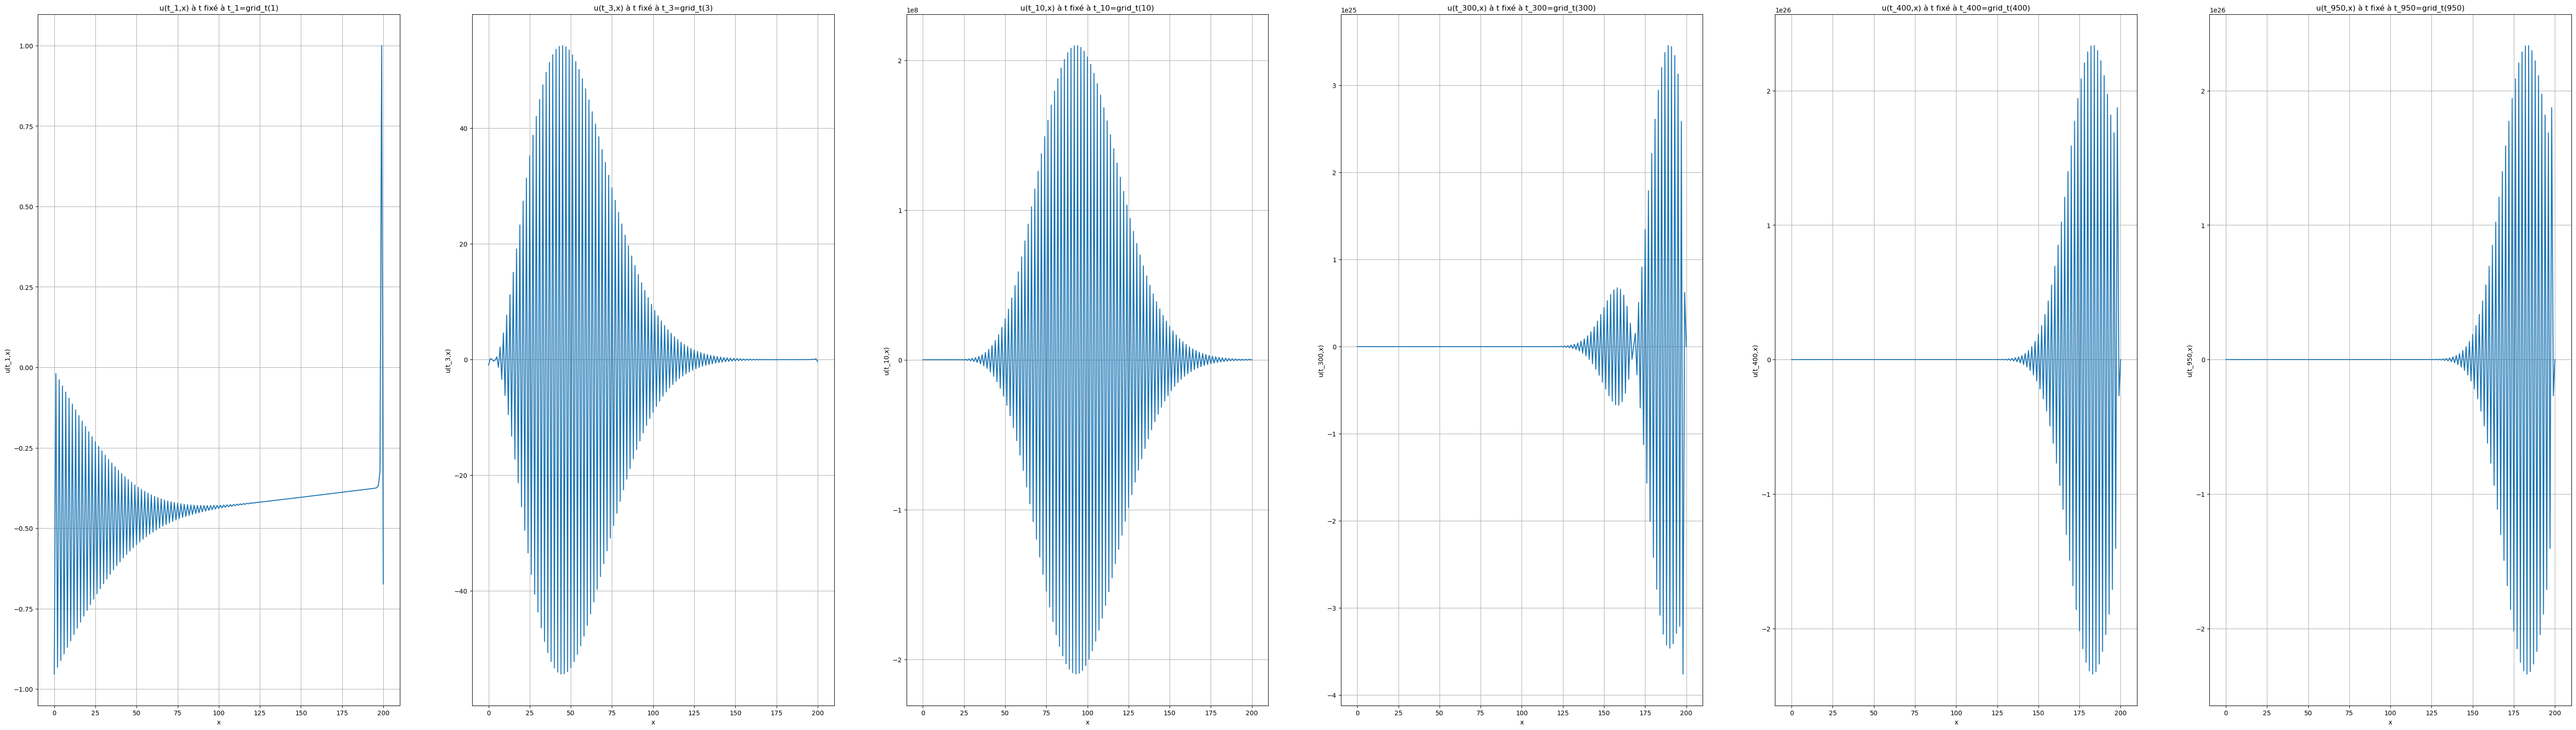

In [31]:
plt.figure(1, figsize=(40, 50))
plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5,
                          top=0.5, wspace=0.2, hspace=0.5)

# Choisir les indices de temps pour lesquels vous souhaitez afficher les graphiques
time_indices = [1, 3, 10, 300, 400, 950]

for i, index in enumerate(time_indices, 1):
    plt.subplot(1, 6, i)
    plt.plot(Solution[index])
    plt.title(f"u(t_{index},x) à t fixé à t_{index}=grid_t({index})")
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f"u(t_{index},x)")

plt.show()

# <center>Modèle de Cox, Ingersoll et Ross (CIR)</center>

Considérons le modèle de structure par terme de Cox, Ingersoll et Ross [1985]. La variable d'état est le taux d'intérêt instantané $ r(t)$, et on suppose que le processus de diffusion qui modélise la dynamique de $r(t)$ est un processus "racine carrée" de type Bessel :

$$r(t_0) = r_0$$
$$ dr(t) = \kappa(\theta - r) \cdot dt + \sigma \sqrt{r} \cdot dW(t) $$

Dans ce modèle, le prix du risque unitaire $ \lambda(t, r)$ est égal à $$ \lambda(t, r) = \frac{\lambda}{\sigma}\sqrt{r} $$.

In [138]:
kappa = 0.8
teta = 0.10
sigm = 0.5
lambd_= 0.05

tmin = 0
tmax = 5
Nt = 101
xmin = 0
xmax = 1
Nx = 51
teta = 0.5 
k = (tmax-tmin)/(Nt-1)
h = (xmax - xmin)/(Nx-1)


Définition des fonctions a ,b ,c ,d , mu, sigma, lambda et r



In [139]:
def mu(t, x):
    return kappa * (teta - x)

def sigma(t, x):
    return sigm * (x**0.5)

def lambd(t, x):
    return lambd_ * x**0.5 / sigm

def r(t, x):
    return x

def a(t, x):
    return 0.5 * (sigma(t, x)**2) * x**2

def b(t, x):
    return mu(t, x) - lambd(t, x) * sigma(t, x)

def c(t, x):
    return r(t, x)

def d(t, x):
    return 0

def tminBound(t, x):
    return 1

In [140]:
#Liste des valeurs de t. Le résultat final est une liste de nombre allant de tmin à tmax avec un pas de h = (tmax - tmin)/(Nt-1)
def grid_t():
    k = (tmax-tmin)/(Nt-1)
    Grid_t=np.zeros(Nt) #On génère la matrice de dimension kx1 qui stockera les valeur de t
    for m in range(Nt):
        Grid_t[m]=tmin + k*m
    return(Grid_t)

In [141]:
#Liste des valeurs de x. Le résultat final est une liste de nombre allant de xmin à xmax avec un pas de h = (xmax - xmin)/(Nx-1)
def grid_x():
    h = (xmax - xmin)/(Nx-1)
    Grid_x=np.zeros(Nx) #On génère la matrice de dimension hx1 qui stockera les valeur de x
    for i in range(Nx):
        Grid_x[i]= xmin + h*i
    return(Grid_x)

La formule du prix d'une obligation zéro-coupon est la suivante :

$$
P_{t_0}^c(\tau) = \left[\frac{2\gamma e^{\frac{\phi_1\tau}{2}}}{\phi_3}\right]^{\phi_4} e^{-\frac{2r_0\phi_2}{\phi_3}}
$$

où :
$$\tau = T - t $$
$$\gamma = (\kappa + \lambda)^2 + 2\sigma^2 $$ 
$$\phi_1 = \gamma + \kappa + \lambda$$
$$\phi_2 = e^{\gamma\tau} - 1$$ 
$$\phi_3 = \phi_1\phi_2 + 2\gamma$$ 
$$\phi_4 = \frac{2\kappa\theta}{\sigma^2}$$


In [142]:
#Condition aux bornes
u_Nx_moins_un=np.ones(Nt)

gamm= np.sqrt((kappa+lambd_)**2+2*sigm**2)
phi1=(kappa+gamm+lambd_)
u_xmin=[]
for t in grid_t():
    phi2=np.exp(gamm*t)-1
    phi3=phi1*phi2+2*gamm
    phi4=2*kappa*teta/(sigm**2)
    u_xmin.append((2*gamm*np.exp(phi1*t/2)/phi3)**(phi4)*np.exp(-2*r(t,grid_x()[0])*phi2/phi3))

In [143]:
ε1=εm(u_xmin,u_Nx_moins_un,0)
print(ε1)

[  1.04640916   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 -14.164875  ]


In [144]:
v1_plus_ε_1 = calcul_vm_plus_εm(u_xmin,ε1,1)

In [82]:
Solution_CIR=[u_xmin]
uprev = u_xmin
ε=ε1
Λ=matrices_Λm(a,b,c,d,teta,0)
for t in range(len(grid_t())):
    v_plus_ε=calcul_vm_plus_εm(uprev,ε,t)
    Solution_CIR.append(TDMASolve(Λ[2],Λ[1],Λ[0],v_plus_ε ))
    uprev=Solution_CIR[-1]
    ε= εm(u_xmin,u_Nx_moins_un,t)
    Λ=matrices_Λm(a,b,c,d,teta,t)

IOStream.flush timed out


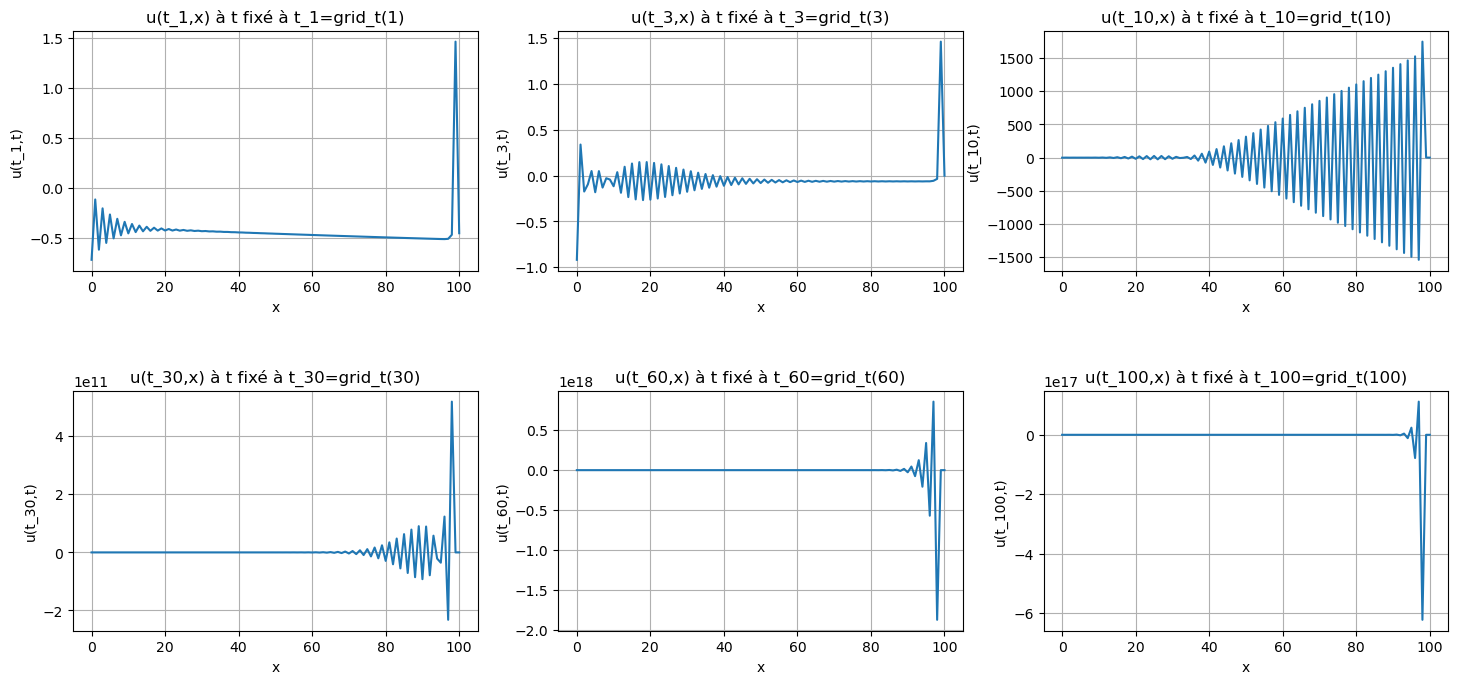

In [85]:
plt.figure(1, figsize=(10, 20))
plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5,
                          top=0.5, wspace=0.2, hspace=0.5)


# Choisissez les indices de temps pour lesquels vous souhaitez afficher les graphiques
time_indices_CIR = [1, 3, 10, 30, 60, 100]

for i, index in enumerate(time_indices_CIR, 1):
    plt.subplot(2, 3, i)
    plt.plot(Solution_CIR[index])
    plt.title(f"u(t_{index},x) à t fixé à t_{index}=grid_t({index})")
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f"u(t_{index},t)")

plt.show()


# <center>Modèle de Vasicek</center>

Le modèle développé par Vasicek [1977] est très proche de celui de Cox, Ingersoll et Ross [1985]. Le taux d'intérêt instantané suit un processus de Ornstein-Uhlenbeck :

$$ r(t_0) = r_0 $$

$$ dr(t) = a(b - r(t)) \cdot dt + \sigma \cdot dW(t) $$

Dans ce modèle, le prix du risque unitaire est supposé constant : $ \lambda(t,r) = \lambda $.

Ce modèle est très intéressant puisqu’il permet de montrer la symétrie des erreurs numériques entre le schéma explicite et le schéma implicite lorsque les fonctions du problème sont indépendantes du temps.
Le schéma de Crank-Nicholson exploite cette propriété et permet de réduire sensiblement l’erreur numérique.

In [88]:
a_ = 0.95
b_ = 0.10
sigm = 0.2
lambd = 0.05
bprime = b_ - lambd*sigm/a_
tmin = 0
tmax = 5
Nt = 1001
xmin = -1
xmax = 1
Nx = 101
k = (tmax-tmin)/(Nt-1)
h = (xmax - xmin)/(Nx-1)
Lteta = [0, 0.25, 0.50, 1, 1.25 ,1.75,2, 2.25, 2.50, 2.75, 3.25, 3.50, 4, 4.25, 4.75, 5]

In [62]:
def a(t,x):
    return(0.5*(sigm**2))

def b(t,x):
    return( a_*(bprime-x))

def r(t,x):
    return(x)

def c(t,x):
    return r(t,x)

def d(t,x):
    return(0)

def tminBound(t,x):
    return 1

In [63]:
#Liste des valeurs de t. Le résultat final est une liste de nombre allant de tmin à tmax avec un pas de h = (tmax - tmin)/(Nt-1)
def grid_t():
    k = (tmax-tmin)/(Nt-1)
    Grid_t=np.zeros(Nt) #On génère la matrice de dimension kx1 qui stockera les valeur de t
    for m in range(Nt):
        Grid_t[m]=tmin + k*m
    return(Grid_t)

In [64]:
#Liste des valeurs de x. Le résultat final est une liste de nombre allant de xmin à xmax avec un pas de h = (xmax - xmin)/(Nx-1)
def grid_x():
    h = (xmax - xmin)/(Nx-1)
    Grid_x=np.zeros(Nx) #On génère la matrice de dimension hx1 qui stockera les valeur de x
    for i in range(Nx):
        Grid_x[i]= xmin + h*i
    return(Grid_x)

Le prix du zéro coupon est donné par la formule suivante :
$$
P_{t_0}^{c}(\tau) = \exp\left[ -(b' - \frac{\sigma^2}{2a^2})\tau - \left( r_0 - b' +\frac{\sigma^2}{2a^2} \right)(\frac{1 - e^{-a\tau}}{a}) - \frac{\sigma^2}{4a^3}(1 - e^{-a\tau})^2 \right]  $$

avec

$$ b' = b - \lambda\frac{\sigma}{a} $$


In [65]:
#Calcul u initial
u_Nx_moins_un=np.zeros(Nt)
u_xmin=[]
for t in grid_t():
    u_xmin.append(np.exp(-(bprime-(sigm**2)/(2*a_**2))*t-(r(grid_t()[0],grid_x()[0])-bprime+(sigm**2)/(2*a_**2))*((1-np.exp(-a_*t))/a_)-(sigm**2)/(4*a_**3)*(1-np.exp(-a_*t)**2)))

In [66]:
Solution_V=[u_xmin]
uprev = u_xmin
ε=ε1
teta=0
Λ=matrices_Λm(a,b,c,d,teta,0)
for t in range(len(grid_t())):
    v_plus_ε=calcul_vm_plus_εm(uprev,ε,t)
    Solution.append(TDMASolve(Λ[2],Λ[1],Λ[0],v_plus_ε ))
    uprev=Solution_V[-1]
    ε= εm(u_xmin,u_Nx_moins_un,t)
    Λ=matrices_Λm(a,b,c,d,teta,t)

In [ ]:
solution_teta=[]
for teta in Lteta:
    Solution_V=[u_xmin]
    uprev = u_xmin
    ε=εm(u_xmin,u_Nx_moins_un,0)
    Λ=matrices_Λm(a,b,c,d,teta,0)
    for t in range(len(grid_t())):
        v_plus_ε=calcul_vm_plus_εm(uprev,ε,t)
        Solution_V.append(TDMASolve(Λ[2],Λ[1],Λ[0],v_plus_ε ))
        uprev=Solution_V[-1]
        ε=εm(u_xmin,u_Nx_moins_un,t)
        Λ=matrices_Λm(a,b,c,d,teta,t)
        solution_teta.append(Solution_V)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


# Solution Teta = 0

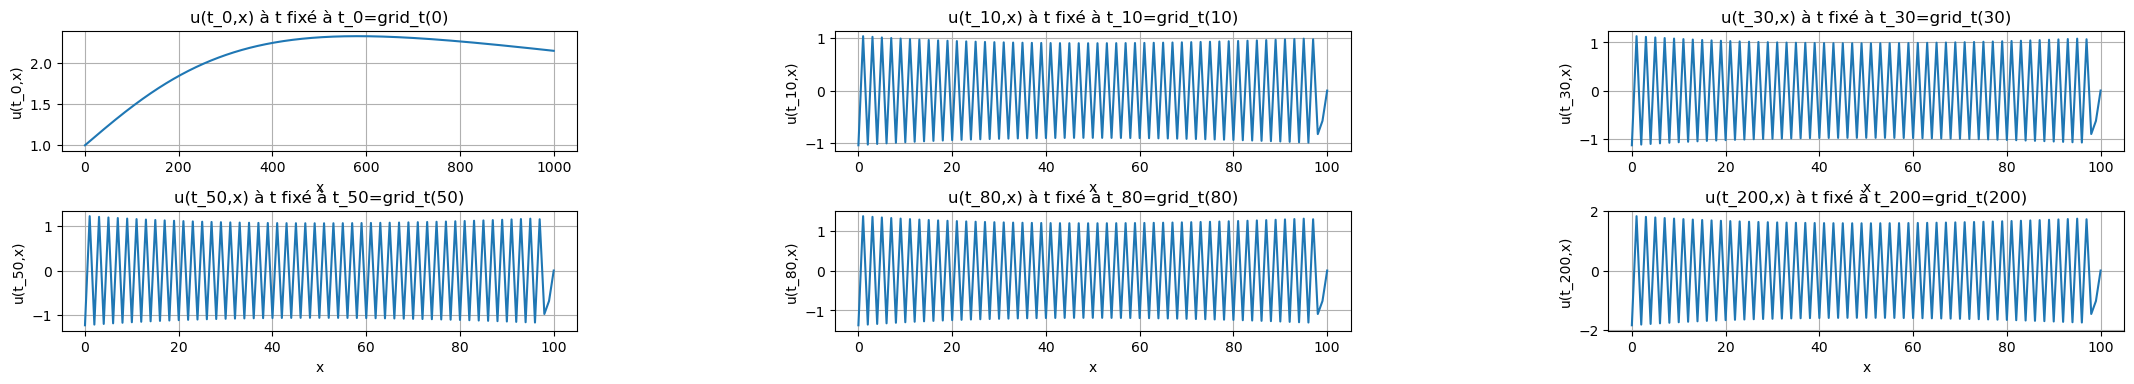

In [76]:
plt.figure(1, figsize=(15, 10))
plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=0.5, wspace=0.5, hspace=0.5)
time_indices = [0, 10]

for i, idx in enumerate(time_indices, start=1):
    plt.subplot(2, 3, i)
    plt.plot(solution_teta[0][idx])
    plt.title(f"u(t_{idx},x) à t fixé à t_{idx}=grid_t({idx})")
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f"u(t_{idx},x)")

plt.show()


# Solution Teta = 2.5

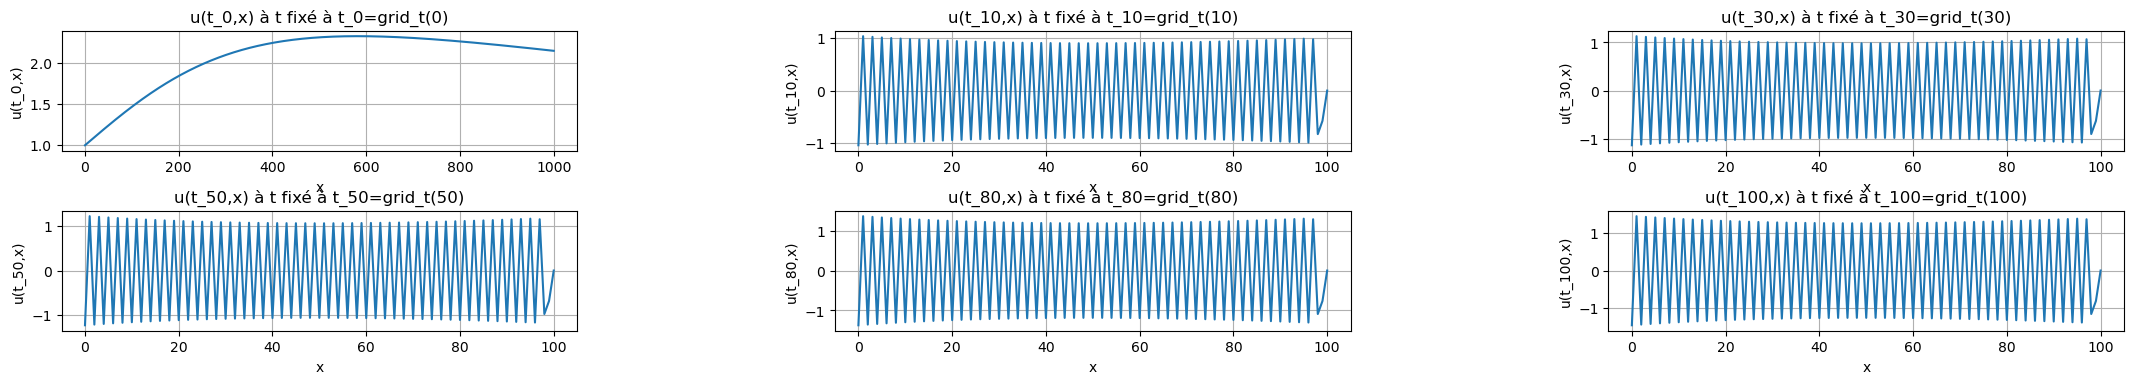

In [77]:

plt.figure(1, figsize=(15, 10))
plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=0.5, wspace=0.5, hspace=0.5)
time_indices = [0, 10]

for i, idx in enumerate(time_indices, start=1):
    plt.subplot(2, 3, i)
    plt.plot(solution_teta[3][idx])
    plt.title(f"u(t_{idx},x) à t fixé à t_{idx}=grid_t({idx})")
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f"u(t_{idx},x)")

plt.show()

# Teta = 4

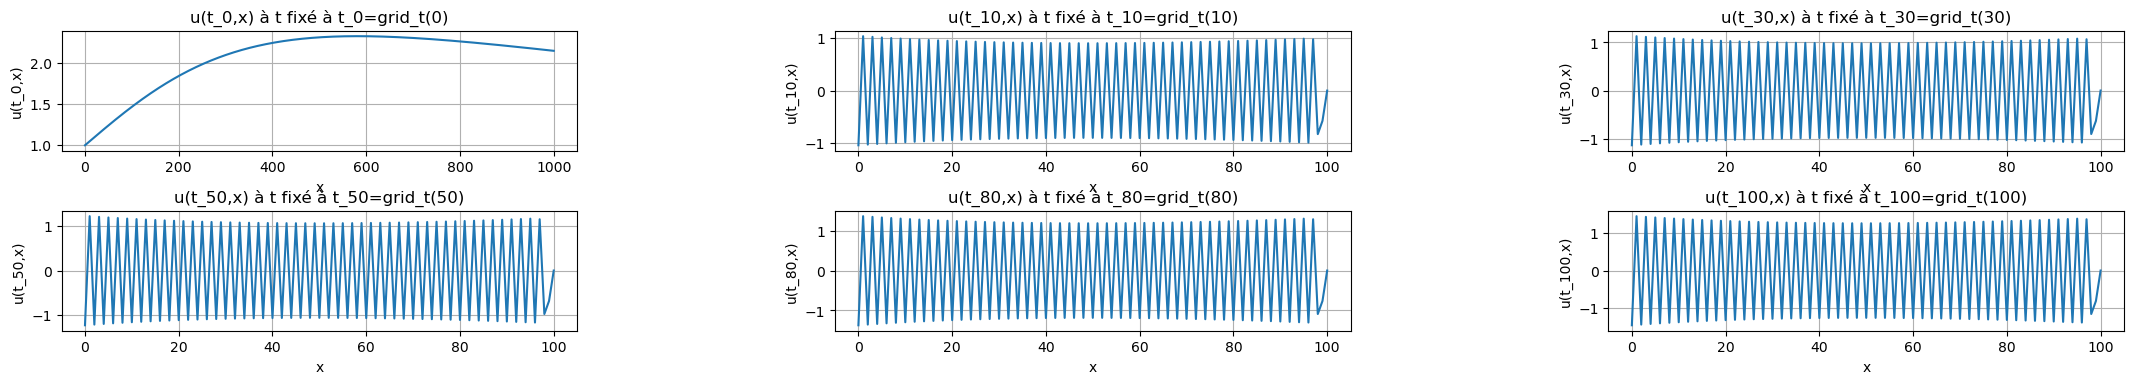

In [73]:
plt.figure(1, figsize=(15, 10))
plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=0.5, wspace=0.5, hspace=0.5)
time_indices = [0, 10]

for i, idx in enumerate(time_indices, start=1):
    plt.subplot(2, 3, i)
    plt.plot(solution_teta[7][idx])
    plt.title(f"u(t_{idx},x) à t fixé à t_{idx}=grid_t({idx})")
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f"u(t_{idx},x)")

plt.show()


# Teta = 5

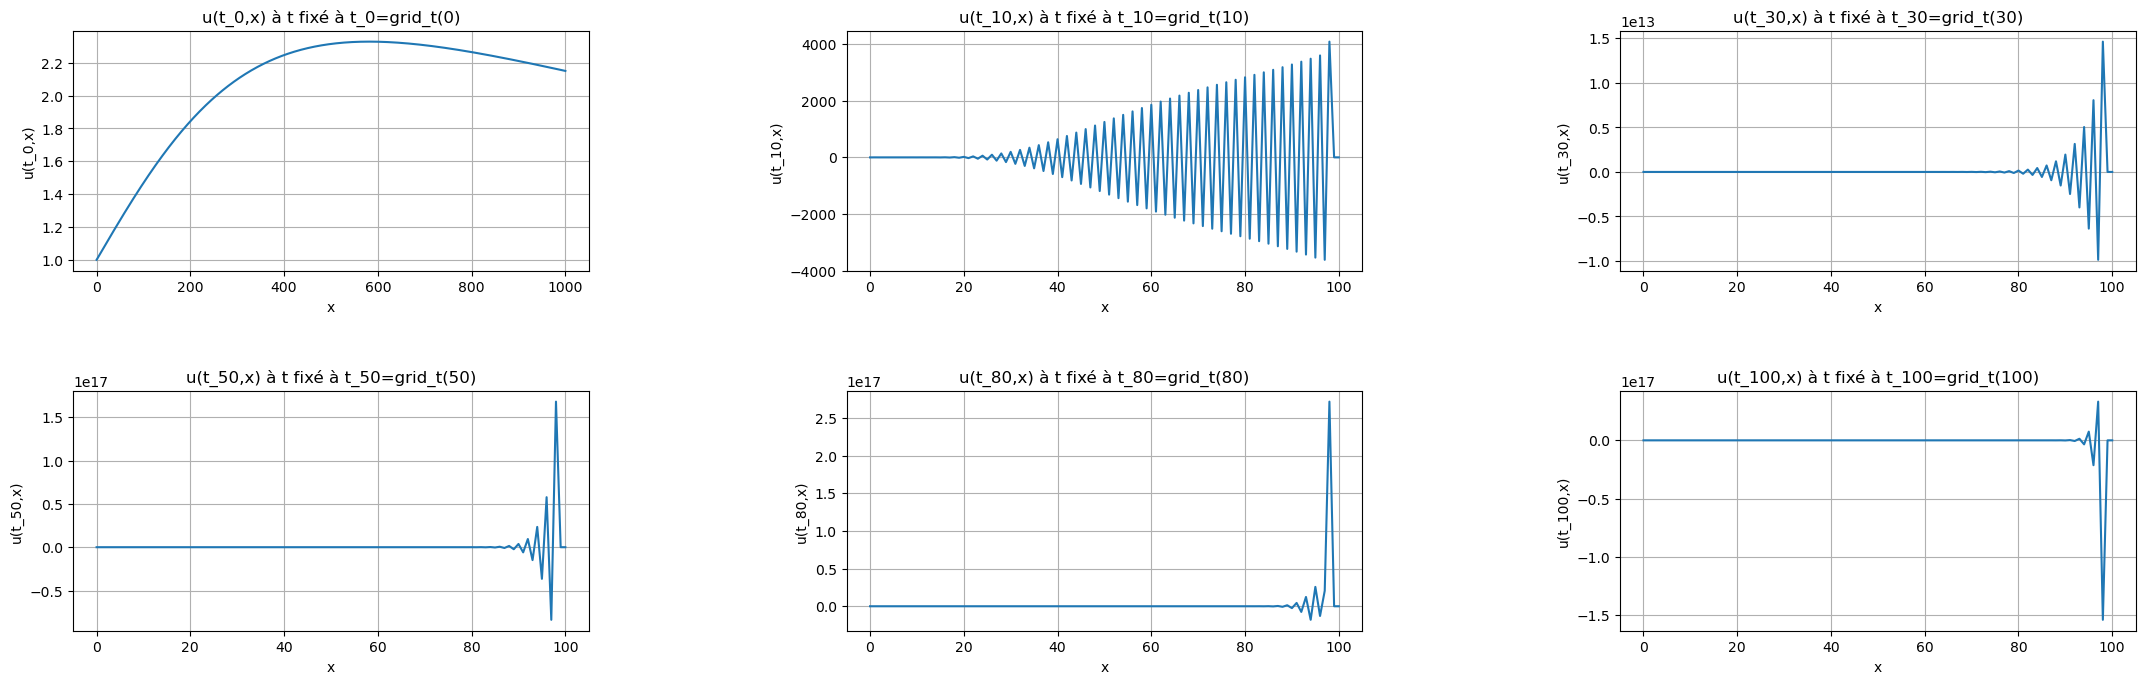

In [80]:
plt.figure(1, figsize=(15, 20))
plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=0.5, wspace=0.5, hspace=0.5)

time_points = [0, 10]

for i, t in enumerate(time_points, start=1):
    plt.subplot(2, 3, i)
    plt.plot(solution_teta[-1][t])
    plt.title(f"u(t_{t},x) à t fixé à t_{t}=grid_t({t})")
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f"u(t_{t},x)")

plt.show()
